# Extract barrier island metrics along transects

Author: Emily Sturdivant, esturdivant@usgs.gov

***

Extract barrier island metrics along transects for Barrier Island Geomorphology Bayesian Network. See the project [README](https://github.com/esturdivant-usgs/BI-geomorph-extraction/blob/master/README.md) and the Methods Report (Zeigler et al., in review). 


## Pre-requisites:
- All the input layers (transects, shoreline, etc.) must be ready. This is performed with the notebook file prepper.ipynb.
- The files servars.py and configmap.py may need to be updated for the current dataset.

## Notes:
- This notebook includes interactive quality checking, which requires the user's attention. For thorough QC'ing, we recommend displaying the layers in ArcGIS, especially to confirm the integrity of values for variables such as distance to inlet (__Dist2Inlet__) and widths of the landmass (__WidthPart__, etc.). 


***

## Import modules

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import io
import arcpy
import pyproj
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import core.functions_warcpy as fwa
import core.functions as fun

In [2]:
print("Date: {}".format(datetime.date.today()))
# print(os.__version__)
# print(sys.__version__)
print('pandas version: {}'.format(pd.__version__))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
# print(io.__version__)
# print(arcpy.__version__)
print('pyproj version: {}'.format(pyproj.__version__))

# print(bi_transect_extractor.__version__)

Date: 2019-10-04
pandas version: 0.20.1
numpy version: 1.11.2
matplotlib version: 1.5.3
pyproj version: 1.9.5.1


### Initialize variables

This cell prompts you for the site, year, and project directory path. `setvars.py` retrieves the pre-determined values for that site in that year from `configmap.py`. The project directory will be used to set up your workspace. It's hidden for security – sorry! I recommend that you type the path somewhere and paste it in.

In [3]:
from core.setvars import *

site (options: ParkerRiver, Myrtle, ShipShoal, Monomoy, CapeLookout, Cedar, Parramore, Wreck, CoastGuard, FireIsland, Smith, Assateague, Assawoman, RhodeIsland, Cobb, CapeHatteras, Metompkin, Rockaway, Fisherman, Forsythe):  CapeLookout
year (options: 2010, 2012, 2014):  2014
Path to project directory (e.g. \\Macolume\dir\FireIsland2014):  ··················································································································································································································································
Invalid pathname. Try again:  ················································


setvars.py initialized variables.
SITE: CapeLookout
MHW: 0.26
MLW: -0.5
Max dune crest height: 2.5
Projection code: 26918



Change the filename variables to match your local files. They should be in an Esri file geodatabase named site+year.gdb in your project directory, which you input above and is the value of the variable `home`. 

In [4]:
# Extended transects: NASC transects extended and sorted, ready to be the base geometry for processing
extendedTrans = os.path.join(home, 'extTrans')

# Tidied transects: Extended transects without overlapping transects
extTrans_tidy = os.path.join(home, 'tidyTrans') 

# Geomorphology points: positions of indicated geomorphic features
ShorelinePts = os.path.join(home, 'CapeLookout2014_SLpts')  # shoreline
dlPts = os.path.join(home, 'CapeLookout2014_DLpts')         # dune toe
dhPts = os.path.join(home, 'CapeLookout2014_DHpts')         # dune crest

# Inlet lines: polyline feature classes delimiting inlet position. Must intersect the full island shoreline
inletLines = os.path.join(home, 'CapeLookout2014_inletLines')

# Full island shoreline: polygon that outlines the island shoreline, MHW on oceanside and MTL on bayside
barrierBoundary = os.path.join(home, 'CapeLookout2014_bndpoly_2sl')  

# Elevation grid: DEM of island elevation at either 5 m or 1 m resolution
elevGrid = os.path.join(home, 'CapeLookout2014_DEM_5m')

# ---
# OPTIONAL - comment out each one that is not available
# ---
# 
# morphdata_prefix = '14CNT01'

# Study area boundary; manually digitize if the barrier island study area does not end at an inlet.
# SA_bounds = os.path.join(home, 'SA_bounds')

# Armoring lines: digitize lines of shorefront armoring to be used if dune toe points are not available.
armorLines = os.path.join(home, 'armorLines')

# Extended transects with Construction, Development, and Nourishment coding
tr_w_anthro = os.path.join(home, 'extTrans_wAnthro')

# Piping Plover Habitat BN raster layers
SubType = os.path.join(home, 'calo14_subtype')   # substrate type
VegType = os.path.join(home, 'calo14_vegtype')   # vegetation type
VegDens = os.path.join(home, 'calo14_vegdens')    # vegetation density
GeoSet = os.path.join(home, 'calo14_geoset')     # geomorphic setting
DisMOSH = os.path.join(home, 'calo14_dismosh')   # distance to moist substrates (MOSH)

# Derivatives of inputs: They will be generated during process if they are not found. 
shoreline = os.path.join(home, 'ShoreBetweenInlets')   # oceanside shoreline between inlets; generated from shoreline polygon, inlet lines, and SA bounds
slopeGrid = os.path.join(home, 'slope_5m')   # Slope at 5 m resolution; generated from DEM

## Transect-averaged values
We work with the shapefile/feature class as a pandas DataFrame as much as possible to speed processing and minimize reliance on the ArcGIS GUI display.

1. Create a pandas dataframe from the transects feature class. In the process, we remove some of the unnecessary fields. The resulting dataframe is indexed by __sort_ID__ with columns corresponding to the attribute fields in the transects feature class. 
2. Add __DD_ID__.
3. Join the values from the transect file that includes the three anthropologic development fields, __Construction__,  __Development__, and __Nourishment__. 

In [4]:
# # Copy feature class to dataframe.
# trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)
# trans_df['DD_ID'] = trans_df[tID_fld] + sitevals['id_init_val']

# # Get anthro fields and join to DF
# if 'tr_w_anthro' in locals():
#     trdf_anthro = fwa.FCtoDF(tr_w_anthro, id_fld=tID_fld, dffields=['Development', 'Nourishment','Construction'])
#     trans_df = fun.join_columns(trans_df, trdf_anthro) 

# # Save
# trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# # Display
# print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
# trans_df.head()

# Add BEARING field to extendedTrans feature class
arcpy.AddGeometryAttributes_management (extendedTrans, 'LINE_BEARING')
print("Adding line bearing field to transects.")

# Copy feature class to dataframe.
trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)
trans_df['DD_ID'] = trans_df[tID_fld] + sitevals['id_init_val']
trans_df['MHW'] = sitevals['MHW']
trans_df.drop('Azimuth', axis=1, inplace=True, errors='ignore')
trans_df.rename_axis({"BEARING": "Azimuth"}, axis=1, inplace=True)

# Get anthro fields and join to DF
if 'tr_w_anthro' in locals():
    trdf_anthro = fwa.FCtoDF(tr_w_anthro, id_fld=tID_fld, dffields=['Development', 'Nourishment','Construction'])
    trans_df = fun.join_columns(trans_df, trdf_anthro) 

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# Display
print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
trans_df.head()

...converting feature class to array...
...converting array to dataframe...
...converting feature class to array...
...converting array to dataframe...

Header of transects dataframe (rows 1-5 out of 1829): 


,Azimuth,LRR,TransOrder,TransectId,sort_ID,DD_ID,Construction,Development,Nourishment
sort_ID,,,,,,,,,
1,39.73,-1.16,3513.0,3513.0,1,40001,111,111,111
2,39.95,-1.29,3514.0,3514.0,2,40002,111,111,111
3,40.17,-1.35,3515.0,3515.0,3,40003,111,111,111
4,40.39,-1.37,3516.0,3516.0,4,40004,111,111,111
5,40.61,-1.43,3517.0,3517.0,5,40005,111,111,111


### Split features between east and west, divided at the southern point (Cape Point)

In [4]:
# West
extendedTrans_west = os.path.join(home, 'extTrans_west')
ShorelinePts_west = os.path.join(home, 'SLpts_west')
dlPts_west = os.path.join(home, 'DLpts_west')
dhPts_west = os.path.join(home, 'DHpts_west')
shoreline_west = os.path.join(home, 'ShoreBetweenInlets_west')

# East
extendedTrans_east = os.path.join(home, 'extTrans_east')
ShorelinePts_east = os.path.join(home, 'SLpts_east')
dlPts_east = os.path.join(home, 'DLpts_east')
dhPts_east = os.path.join(home, 'DHpts_east')
shoreline_east = os.path.join(home, 'ShoreBetweenInlets_east')

In [5]:
# Sort by ID before selecting by index
trans_df = trans_df.sort_values(by=tID_fld)

# Select transects on west of spit
trans_west = trans_df.loc[:405, :]
trans_west.to_pickle(os.path.join(scratch_dir, 'trans_west_df.pkl'))

# Select transects on east of spit
trans_east = trans_df.loc[406:, :]
trans_east.to_pickle(os.path.join(scratch_dir, 'trans_east_df.pkl'))

In [5]:
# Read original
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))
trans_west = pd.read_pickle(os.path.join(scratch_dir, 'trans_west_df.pkl'))
trans_east = pd.read_pickle(os.path.join(scratch_dir, 'trans_east_df.pkl'))
print("Length of trans_df: ", len(trans_df))
print("Length of trans_west: ", len(trans_west))
print("Length of trans_east: ", len(trans_east))

Length of trans_df:  1829
Length of trans_west:  405
Length of trans_east:  1424


### Get XY and Z/slope from SL, DH, DL points within 25 m of transects
Add to each transect row the positions of the nearest pre-created beach geomorphic features (shoreline, dune toe, and dune crest).

#### If needed, convert morphology points stored locally to feature classes for use.
After which, view the new feature classes in a GIS. Isolate the points to the region of interest. Quality check them. Then copy them for use with this code, which will require setting the filenames to match those included here or changing the values included here to match the final filenames.

In [6]:
if "morphdata_prefix" in locals():
    csvpath = os.path.join(proj_dir, 'Input_Data', '{}_morphology'.format(morphdata_prefix), 
                           '{}_morphology.csv'.format(morphdata_prefix))
    dt_fc, dc_fc, sl_fc = fwa.MorphologyCSV_to_FCsByFeature(csvpath, state, proj_code, 
                                                            csv_fill = 999, fc_fill = -99999, csv_epsg=4326)
    print("OUTPUT: morphology point feature classes in the scratch gdb. We recommend QC before proceeding.")

#### Shoreline

The MHW shoreline easting and northing (__SL_x__, __SL_y__) are the coordinates of the intersection of the oceanside shoreline with the transect. Each transect is assigned the foreshore slope (__Bslope__) from the nearest shoreline point within 25 m. These values are populated for each transect as follows: 
1. get __SL_x__ and __SL_y__ at the point where the transect crosses the oceanside shoreline; 
2. find the closest shoreline point to the intersection point (must be within 25 m) and copy the slope value from the point to the transect in the field __Bslope__.

In [7]:
if not arcpy.Exists(inletLines):
    # manually create lines that correspond to end of land and cross the MHW line (refer to shoreline polygon)
    arcpy.CreateFeatureclass_management(home, os.path.basename(inletLines), 'POLYLINE', spatial_reference=utmSR)
    print("OUTPUT: {}. Interrupt execution to manually create lines at each inlet.".format(inletLines))

if not arcpy.Exists(shoreline):
    if not 'SA_bounds' in locals(): 
        SA_bounds = ''
    shoreline = fwa.CreateShoreBetweenInlets(barrierBoundary, inletLines, shoreline, ShorelinePts, proj_code, SA_bounds)

#%% Shoreline
# West: Get the XY position where transect crosses the oceanside shoreline
sl2trans_west = fwa.add_shorelinePts2Trans(extendedTrans_west, ShorelinePts_west, shoreline_west, 
                                         tID_fld, proximity=pt2trans_disttolerance)
sl2trans_west.to_pickle(os.path.join(scratch_dir, 'sl2trans_west.pkl'))

# East: Get the XY position where transect crosses the oceanside shoreline
sl2trans_east = fwa.add_shorelinePts2Trans(extendedTrans_east, ShorelinePts_east), shoreline_east, 
                                         tID_fld, proximity=pt2trans_disttolerance)
sl2trans_east.to_pickle(os.path.join(scratch_dir, 'sl2trans_east.pkl'))


Matching shoreline points to transects...
Using field 'slope' as slope.
...duration at transect 100: 0:0:38.4 seconds
...duration at transect 200: 0:1:15.3 seconds
...duration at transect 300: 0:1:50.8 seconds
...duration at transect 400: 0:2:19.0 seconds
Duration: 0:2:28.9 seconds

Matching shoreline points to transects...
Using field 'slope' as slope.
...duration at transect 100: 0:1:31.7 seconds
...duration at transect 200: 0:2:56.9 seconds
...duration at transect 300: 0:4:22.7 seconds
...duration at transect 400: 0:5:30.1 seconds
...duration at transect 500: 0:6:4.8 seconds
...duration at transect 600: 0:7:32.3 seconds
...duration at transect 700: 0:9:0.4 seconds
...duration at transect 800: 0:10:26.7 seconds
...duration at transect 900: 0:11:53.4 seconds
...duration at transect 1000: 0:13:19.3 seconds
...duration at transect 1100: 0:14:45.9 seconds
...duration at transect 1200: 0:16:11.7 seconds
...duration at transect 1300: 0:17:37.1 seconds
...duration at transect 1400: 0:19:3.

In [13]:
# East: Get the XY position where transect crosses the oceanside shoreline
sl2trans_east = fwa.add_shorelinePts2Trans(extendedTrans_east, ShorelinePts_east, shoreline_east, 
                                           tID_fld, proximity=pt2trans_disttolerance)
sl2trans_east.to_pickle(os.path.join(scratch_dir, 'sl2trans_east.pkl'))


Matching shoreline points to transects...
Using field 'slope' as slope.
...duration at transect 500: 0:0:22.8 seconds
...duration at transect 600: 0:1:21.3 seconds
...duration at transect 700: 0:2:18.8 seconds
...duration at transect 800: 0:3:15.3 seconds
...duration at transect 900: 0:4:14.8 seconds
...duration at transect 1000: 0:5:18.2 seconds
...duration at transect 1100: 0:6:19.3 seconds
...duration at transect 1200: 0:7:17.4 seconds
...duration at transect 1300: 0:8:14.1 seconds
...duration at transect 1400: 0:9:8.8 seconds
...duration at transect 1500: 0:10:3.4 seconds
...duration at transect 1600: 0:10:57.6 seconds
...duration at transect 1700: 0:11:51.9 seconds
...duration at transect 1800: 0:12:47.5 seconds
Duration: 0:13:40.6 seconds


#### Dune positions along transects

__DL_x__, __DL_y__, and __DL_z__ are the easting, northing, and elevation, respectively, of the nearest dune toe point within 25 meters of the transect. __DH_x__, __DH_y__, and __DH_z__ are the easting, northing, and elevation, respectively, of the nearest dune crest point within 25 meters. 

__DL_snapX__, __DL_snapY__, __DH_snapX__, and __DH_snapY__ are the eastings and northings of the points "snapped" to the transect. "Snapping" finds the position along the transect nearest to the point, i.e. orthogonal to the transect. These values are used to find the beach width. The elevation values are not snapped; we use the elevation values straight from the original points. 

These values are populated as follows: 

1. Find the nearest dune crest/toe point to the transect and proceed if the distance is less than 25 m. If there are no points within 25 m of the transect, populate the row with Null values.
2. Get the X, Y, and Z values of the point. 
3. Find the position along the transect of an orthogonal line drawn to the dune point (__DL_snapX__, __DL_snapY__, __DH_snapX__, and __DH_snapY__). This is considered the 'snapped' XY position and is calculated using the arcpy geometry method. 

In [151]:
# West: Create dataframe for both dune crest and dune toe positions
dune2trans_west = fwa.find_ClosestPt2Trans_snap(extendedTrans_west, dhPts_west, dlPts_west, trans_west, 
                                          tID_fld, proximity=pt2trans_disttolerance)
dune2trans_west.to_pickle(os.path.join(scratch_dir, 'dune2trans_west.pkl'))

# East: Create dataframe for both dune crest and dune toe positions
dune2trans_east = fwa.find_ClosestPt2Trans_snap(extendedTrans_east, dhPts_east, dlPts_east, trans_east, 
                                          tID_fld, proximity=pt2trans_disttolerance)
dune2trans_east.to_pickle(os.path.join(scratch_dir, 'dune2trans_east.pkl'))


Matching dune points with transects:
Using field 'dhigh_z' as DH Z field...
Using field 'dlow_z' as DL Z field...
Looping through transects and dune points to find nearest point within 25 m...
...duration at transect 100: 0:1:1.3 seconds
...duration at transect 200: 0:1:54.0 seconds
...duration at transect 300: 0:2:46.3 seconds
...duration at transect 400: 0:3:27.5 seconds
Duration: 0:3:41.8 seconds

Matching dune points with transects:
Using field 'dhigh_z' as DH Z field...
Using field 'dlow_z' as DL Z field...
Looping through transects and dune points to find nearest point within 25 m...
...duration at transect 500: 0:0:58.8 seconds
...duration at transect 600: 0:3:25.8 seconds
...duration at transect 700: 0:5:53.9 seconds
...duration at transect 800: 0:8:22.0 seconds
...duration at transect 900: 0:10:49.4 seconds
...duration at transect 1000: 0:13:19.3 seconds
...duration at transect 1100: 0:15:49.9 seconds
...duration at transect 1200: 0:18:20.6 seconds
...duration at transect 130

#### Armoring
__Arm_x__, __Arm_y__, and __Arm_z__ are the easting, northing, and elevation, respectively, where an artificial structure crosses the transect in the vicinity of the beach. These features are meant to supplement the dune toe data set by providing an upper limit to the beach in areas where dune toe extraction was confounded by the presence of an artificial structure. Values are populated for each transect as follows: 

1. Get the positions of intersection between the digitized armoring lines and the transects (Intersect tool from the Overlay toolset); 
2. Extract the elevation value at each intersection point from the DEM (Extract Multi Values to Points tool from Spatial Analyst); 

In [9]:
# Armoring line
arm2trans_west = fwa.ArmorLineToTrans_PD(extendedTrans_west, armorLines, sl2trans_west, tID_fld, proj_code, elevGrid)
arm2trans_west.to_pickle(os.path.join(scratch_dir, 'arm2trans_west.pkl'))

# Armoring line
arm2trans_east = fwa.ArmorLineToTrans_PD(extendedTrans_east, armorLines, sl2trans_east, tID_fld, proj_code, elevGrid)
arm2trans_east.to_pickle(os.path.join(scratch_dir, 'arm2trans_east.pkl'))


Armoring file either missing or empty so we will proceed without armoring data. If shorefront tampering is present at this site, cancel the operations to digitize.

Armoring file either missing or empty so we will proceed without armoring data. If shorefront tampering is present at this site, cancel the operations to digitize.


#### Rerun east extraction

### Import saved dataframes and concatenate them all to trans_df

In [6]:
# Load saved dataframes
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))
trans_west = pd.read_pickle(os.path.join(scratch_dir, 'trans_west_df.pkl'))
trans_east = pd.read_pickle(os.path.join(scratch_dir, 'trans_east_df.pkl'))

sl2trans_west = pd.read_pickle(os.path.join(scratch_dir, 'sl2trans_west.pkl'))
sl2trans_east = pd.read_pickle(os.path.join(scratch_dir, 'sl2trans_east.pkl'))

dune2trans_west = pd.read_pickle(os.path.join(scratch_dir, 'dune2trans_west.pkl'))
dune2trans_east = pd.read_pickle(os.path.join(scratch_dir, 'dune2trans_east.pkl'))

arm2trans_west = pd.read_pickle(os.path.join(scratch_dir, 'arm2trans_west.pkl'))
arm2trans_east = pd.read_pickle(os.path.join(scratch_dir, 'arm2trans_east.pkl'))

In [14]:
# West: Join positions of shoreline, dune crest, dune toe, armoring
trans_west = fun.join_columns_id_check(trans_west, sl2trans_west, tID_fld)
trans_west = fun.join_columns_id_check(trans_west, dune2trans_west, tID_fld)
trans_west = fun.join_columns_id_check(trans_west, arm2trans_west, tID_fld)
# Save
trans_west.to_pickle(os.path.join(scratch_dir, 'trans_west_beachmetrics.pkl'))

# East: Join positions of shoreline, dune crest, dune toe, armoring
trans_east = fun.join_columns_id_check(trans_east, sl2trans_east, tID_fld)
trans_east = fun.join_columns_id_check(trans_east, dune2trans_east, tID_fld)
trans_east = fun.join_columns_id_check(trans_east, arm2trans_east, tID_fld)
# Save
trans_east.to_pickle(os.path.join(scratch_dir, 'trans_east_beachmetrics.pkl'))

# Concatenate the east-west transect dataframe
trans_eastwest_df = pd.concat([trans_west, trans_east])
trans_eastwest_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics_concat.pkl'))
trans_eastwest_df.head()

# Concatenate the east-west morphology dataframes
sl2trans_df = pd.concat([sl2trans_west, sl2trans_east])
sl2trans_df.to_pickle(os.path.join(scratch_dir, 'sl2trans_concat.pkl'))

dune2trans_df = pd.concat([dune2trans_west, dune2trans_east])
dune2trans_df.to_pickle(os.path.join(scratch_dir, 'dune2trans_concat.pkl'))

arm2trans_df = pd.concat([arm2trans_west, arm2trans_east])

### Check for errors
*Optional*

Display summary stats / histograms and create feature classes. The feature classes display the locations that will be used to calculate beach width. Review the output feature classes in a GIS to validate. 

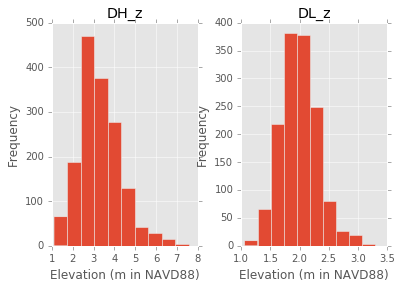

In [85]:
plots = trans_df.hist(['DH_z', 'DL_z', 'Arm_z'])

# Subplot Labels
plots[0][0].set_xlabel("Elevation (m in NAVD88)")
plots[0][0].set_ylabel("Frequency")
plots[0][1].set_xlabel("Elevation (m in NAVD88)")
plots[0][1].set_ylabel("Frequency")
try:
    plots[0][2].set_xlabel("Elevation (m in NAVD88)")
    plots[0][2].set_ylabel("Frequency")
except:
    pass

plt.show()
plt.close()

In [82]:
# Convert dataframe to feature class - shoreline points with slope
fwa.DFtoFC(sl2trans_df, os.path.join(arcpy.env.workspace, 'pts2trans_SL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["SL_x", "SL_y"], keep_fields=['Bslope'])
print('OUTPUT: pts2trans_SL in designated scratch geodatabase.')

# Dune crests
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.workspace, 'ptSnap2trans_DH'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DH_snapX", "DH_snapY"], keep_fields=['DH_z'])
    print('OUTPUT: ptSnap2trans_DH in designated scratch geodatabase.')
except Exception as err:
    print(err)
    pass

# Dune toes
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.workspace, 'ptSnap2trans_DL'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DL_snapX", "DL_snapY"], keep_fields=['DL_z'])
    print('OUTPUT: ptSnap2trans_DL in designated scratch geodatabase.')
except Exception as err:
    print(err)

    pass

... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: pts2trans_SL in designated scratch geodatabase.
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: ptSnap2trans_DH in designated scratch geodatabase.
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: ptSnap2trans_DL in designated scratch geodatabase.


### Calculate upper beach width and height
Upper beach width (__uBW__) and upper beach height (__uBH__) are calculated based on the difference in position between two points: the position of MHW along the transect (__SL_x__, __SL_y__) and the dune toe position or equivalent (usually __DL_snapX__, __DL_snapY__).  In some cases, the dune toe is not appropriate to designate the "top of beach" so beach width and height are calculated from either the position of the dune toe, the dune crest, or the base of an armoring structure. The dune crest was only considered a possibility if the dune crest elevation (__DH_zMHW__) was less than or equal to `maxDH`. 

They are calculated as follows: 
2. Calculate distances from MHW to the position along the transect of the dune toe (__DistDL__), dune crest (__DistDH__), and armoring (__DistArm__). 
2. Adjust the elevations to MHW, populating fields __DH_zmhw__, __DL_zmhw__, and __Arm_zmhw__. 
3. Conditionally select the appropriate feature to represent "top of beach." Dune toe is prioritized. If it is not available and __DH_zmhw__ is less than or equal to maxDH, use dune crest. If neither of the dune positions satisfy the conditions and an armoring feature intersects with the transect, use the armoring position. If none of the three are possible, __uBW__ and __uBH__ will be null. 
4. Copy the distance to shoreline and height above MHW (__Dist--__, __---zmhw__) to __uBW__ and __uBH__, respectively. 

Notes:
- In some morphology datasets, missing elevation values at a point indicate that the point should not be used to measure beach width. In those cases, use the `skip_missing_z` argument to select whether or not to skip these points. 

In [18]:
# Load saved dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics_concat.pkl'))

In [21]:
# Calculate distances from shore to dunes, etc.
trans_df  = fwa.calc_BeachWidth_fill(extendedTrans, trans_df, maxDH, tID_fld, 
                                     sitevals['MHW'], fill, skip_missing_z=True)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_ubw.pkl'))

Fields uBW and uBH populated with beach width and beach height.


Beach width at transects 440-478 should be less than 200 m, but when it measures uBW to DL on the other side of the point, it is much greater.

In [20]:
trans_df.loc[440:478, 'uBW'] 

sort_ID
440    158.073079
441    129.490809
442    117.414787
443    120.234516
444    106.271561
445     88.956081
446     83.513466
447     78.750384
448     73.867341
449     66.148069
450     68.440056
451     54.995459
452     62.909569
453     85.201482
454    102.112504
455     70.588285
456     62.927295
457     96.654861
458     53.382825
459     47.921813
460     49.985149
461     52.567304
462     52.390384
463     52.375759
464     47.708367
465     45.722679
466     45.685715
467     44.931898
468     47.952992
469     42.529006
470     41.326411
471     44.260440
472     48.086733
473     43.738311
474     41.214931
475     40.816214
476     41.928346
477     35.728735
478     34.792700
Name: uBW, dtype: float64

### Dist2Inlet


Distance to nearest tidal inlet (__Dist2Inlet__) is computed as alongshore distance of each sampling transect from the nearest tidal inlet. This distance includes changes in the path of the shoreline instead of simply a Euclidean distance and reflects sediment transport pathways. It is measured using the oceanside shoreline between inlets (ShoreBetweenInlets). 

Note that the ShoreBetweenInlets feature class must be both 'dissolved' and 'singlepart' so that each feature represents one-and-only-one shoreline that runs the entire distance between two inlets or equivalent. If the shoreline is bounded on both sides by an inlet, measure the distance to both and assign the minimum distance of the two. If the shoreline meets only one inlet (meaning the study area ends before the island ends), use the distance to the only inlet. 

The process uses the cut, disjoint, and length geometry methods and properties in ArcPy data access module. The function measure_Dist2Inlet() prints a warning when the difference in Dist2Inlet between two consecutive transects is greater than 300. 

In [88]:
# Calc Dist2Inlet in new dataframe - better alternative to the newly created extTrans_dist2inlet
dist_df = fwa.measure_Dist2Inlet(shoreline, extTrans_tidy, inletLines, tID_fld)

# Join to transects
trans_df = fun.join_columns_id_check(trans_df, dist_df, tID_fld, fill=fill)

# Save and view last 10 rows
dist_df.to_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))
dist_df.tail(10)

CAUTION: Large change in Dist2Inlet values between transects 425 (987    5976.292955
Name: Dist2Inlet, dtype: float64 m) and 426 (8770.100115386611 m).
Duration: 0:0:52.5 seconds


,Dist2Inlet
sort_ID,
1815.0,997.152341
1816.0,940.351918
1817.0,882.595500
1818.0,826.355431
1819.0,770.333995
1820.0,714.920981
1821.0,654.867628
1822.0,591.218313
1823.0,513.767722


In [24]:
# Import saved df
dist_df = pd.read_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_ubw.pkl'))

# Join dist2inlet df to trans df
trans_df = fun.join_columns_id_check(trans_df, dist_df, tID_fld, fill=fill)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_dist2inlet.pkl'))

### Clip transects, get barrier widths
Calculates __WidthLand__, __WidthFull__, and __WidthPart__, which measure different flavors of the cross-shore width of the barrier island. __WidthLand__ is the above-water distance between the back-barrier and seaward MHW shorelines. __WidthLand__ only includes regions of the barrier within the shoreline polygon (bndpoly_2sl) and does not extend into any of the sinuous or intervening back-barrier waterways and islands. __WidthFull__ is the total distance between the back-barrier and seaward MHW shorelines (including space occupied by waterways). __WidthPart__ is the width of only the most seaward portion of land within the shoreline. 

These are calculated as follows: 

1. Clip the transect to the full island shoreline (Clip in the Analysis toolbox); 
2. For __WidthLand__, get the length of the multipart line segment from &quot;SHAPE@LENGTH&quot; feature class attribute. When the feature is multipart, this will include only the remaining portions of the transect; 
3. For __WidthPart__, convert the clipped transect from multipart to singlepart and get the length of the first line segment, which should be the most seaward; 
4. For __WidthFull__, calculate the distance between the first vertex and the last vertex of the clipped transect (Feature Class to NumPy Array with explode to points, pandas groupby, numpy hypot).

In [90]:
# Clip transects, get barrier widths
widths_df = fwa.calc_IslandWidths(extendedTrans, barrierBoundary, tID_fld=tID_fld)

# # Save
widths_df.to_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, widths_df, tID_fld, fill=fill)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))
trans_df.sample(5)

Clipping the transects to the barrier island boundaries ('clip2island')...
Getting the width along each transect of the oceanside land (WidthPart)...
...converting feature class to array...
...converting array to dataframe...
Getting the width along each transect of the entire barrier (WidthFull)...
Converting feature class vertices to array with X and Y...
...converting array to dataframe...
Getting the width along each transect of above water portion of the barrier (WidthLand)...


,Azimuth,LRR,TransOrder,TransectId,DD_ID,Construction,Development,Nourishment,SL_x,SL_y,...,DistDL,DistDH,DistArm,uBW,uBH,ub_feat,Dist2Inlet,WidthFull,WidthLand,WidthPart
sort_ID,,,,,,,,,,,,,,,,,,,,,
1233,317.50,-0.14,951.0,951.0,41233,111,111,111,383044.8111,3.860630e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,13.996170,1166.946422,1063.536989,682.165758
319,NaN,NaN,NaN,NaN,40319,111,111,111,357426.6395,3.831890e+06,...,NaN,193.936548,NaN,193.936548,1.462671,DH,1830.279831,283.625038,283.625038,283.625038
1535,317.00,0.05,1253.0,1253.0,41535,111,111,111,394134.2496,3.870857e+06,...,65.261795,80.240554,NaN,65.261795,1.663775,DL,15019.381473,850.391459,828.699935,533.635447
835,307.69,-0.31,553.0,553.0,40835,111,111,111,369729.6559,3.845804e+06,...,48.067957,110.473593,NaN,48.067957,1.250977,DL,13050.210573,1763.070384,811.794062,296.428182
1387,314.62,0.14,1105.0,1105.0,41387,111,111,111,388761.2796,3.865754e+06,...,58.425554,67.134485,NaN,58.425554,2.132336,DL,7596.852150,515.000673,515.000673,515.000673


In [27]:
# Import saved df
widths_df = pd.read_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_dist2inlet.pkl'))

# Join dist2inlet df to trans df
trans_df = fun.join_columns_id_check(trans_df, widths_df, tID_fld, fill=fill)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))
trans_df.sample(5)

,Azimuth,LRR,TransOrder,TransectId,DD_ID,Construction,Development,Nourishment,SL_x,SL_y,...,DistDL,DistDH,DistArm,uBW,uBH,ub_feat,Dist2Inlet,WidthFull,WidthLand,WidthPart
sort_ID,,,,,,,,,,,,,,,,,,,,,
1725,321.30,-0.28,1443.0,1443.0,41725,111,111,111,401255.2854,3.877179e+06,...,NaN,246.361271,NaN,246.361271,1.358278,DH,5594.273767,1530.029364,1425.834544,963.683417
397,59.70,-5.07,111.0,111.0,40397,111,111,111,359074.8152,3.828604e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,5569.528197,393.550376,393.550376,393.550376
1227,317.02,-0.20,945.0,945.0,41227,111,111,111,382845.6830,3.860398e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,331.758010,1101.252512,1101.252512,1101.252512
1537,317.03,0.06,1255.0,1255.0,41537,111,111,111,394208.1222,3.870925e+06,...,129.751314,90.863286,NaN,129.751314,1.531745,DL,15026.590849,693.965173,693.965173,693.965173
1139,NaN,NaN,NaN,NaN,41139,111,111,111,379587.8110,3.857435e+06,...,152.889756,160.372941,NaN,152.889756,1.464063,DL,1897.145472,618.093329,618.093329,618.093329


## 5-m Points
The point dataset samples the land every 5 m along each shore-normal transect. 

### Split transects into points at 5-m intervals. 

The point dataset is created from the tidied transects (tidyTrans, created during pre-processing) as follows: 

1. Clip the tidied transects (tidyTrans) to the shoreline polygon (bndpoly_2sl) , retaining only those portions of the transects that represent land.
2. Produce a dataframe of point positions along each transect every 5 m starting from the ocean-side shoreline. This uses the positionAlongLine geometry method accessed with a Search Cursor and saves the outputs in a new dataframe. 
3. Create a point feature class from the dataframe. 

In [91]:
pts_df, pts_presort = fwa.TransectsToPointsDF(extTrans_tidy, barrierBoundary, fc_out=pts_presort)
print("OUTPUT: '{}' in scratch geodatabase.".format(os.path.basename(pts_presort)))

# Save
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_presort.pkl'))

Clipping transects to within the shoreline bounds ('tidytrans_clipped')...
Getting points every 5m along each transect and saving in new dataframe...
Converting dataframe to feature class ('transPts_unsorted')...
... converting dataframe to array... 
... converting array to feature class... 

Duration: 0:28:51.5 seconds
OUTPUT: 'transPts_unsorted' in scratch geodatabase.


### Add Elevation and Slope to points

__ptZ__ (later __ptZmhw__) and __ptSlp__ are the elevation and slope at the 5-m cell corresponding to the point. 
1. Create the slope and DEM rasters if they don't already exist. We use the 5-m DEM to generate a slope surface (Slope tool in 3D Analyst). 
2. Use Extract Multi Values to Points tool in Spatial Analyst. 
3. Convert the feature class back to a dataframe.

In [92]:
# Create slope raster from DEM
if not arcpy.Exists(slopeGrid):
    arcpy.Slope_3d(elevGrid, slopeGrid, 'PERCENT_RISE')
    print("OUTPUT: slope file in designated home geodatabase.")
    
# Add elevation and slope values at points.
arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[elevGrid, 'ptZ'], [slopeGrid, 'ptSlp']])
print("OUTPUT: added slope and elevation to '{}' in designated scratch geodatabase.".format(os.path.basename(pts_presort)))

# Save
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_extractedZ_presort.pkl'))

OUTPUT: added slope and elevation to 'transPts_unsorted' in designated scratch geodatabase.


In [95]:
if 'SubType' in locals():
    # Add substrate type, geomorphic setting, veg type, veg density values at points.
    arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[SubType, 'SubType'], [VegType, 'VegType'], 
                                                           [VegDens, 'VegDens'], [GeoSet, 'GeoSet'],
                                                            [DisMOSH, 'DisMOSH']])

    # Convert to dataframe
    pts_df = fwa.FCtoDF(pts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp', 'SubType', 
                                                             'VegType', 'VegDens', 'GeoSet','DisMOSH'])
    # Recode fill values
    pts_df.replace({'GeoSet': {9999:np.nan}, 'SubType': {9999:np.nan}, 'VegType': {9999:np.nan},
                    'VegDens': {9999:np.nan}, 'DisMOSH': {9999:np.nan}}, inplace=True)
else:
    print("Plover BN layers not specified (we only check for SubType), so we'll proceed without them. ")
    # Convert to dataframe
    pts_df = fwa.FCtoDF(pts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp'])

# Save and view sample
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
pts_df.sample(5)

Converting feature class to array with X and Y...
...converting array to dataframe...


,DisMOSH,GeoSet,SHAPE@X,SHAPE@Y,SubType,VegDens,VegType,ptSlp,ptZ,sort_ID
9928,99999.0,7.0,402618.9326,3.880038e+06,NaN,888.0,99.0,7.185741,0.589189,1778.0
153383,99999.0,6.0,368460.5257,3.847101e+06,3333.0,NaN,NaN,1.466296,0.211583,840.0
31040,99999.0,7.0,403949.1704,3.879200e+06,7777.0,888.0,88.0,4.223114,1.413922,1791.0
207389,99999.0,5.0,353898.7199,3.837355e+06,7777.0,888.0,88.0,1.705361,1.742247,134.0
216869,99999.0,5.0,362433.1663,3.835915e+06,NaN,888.0,99.0,0.835167,1.441857,590.0


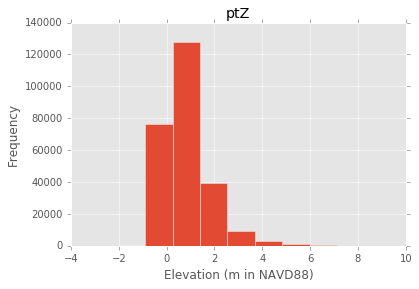

In [96]:
# Print histogram of elevation extracted to points
plots = pts_df.hist('ptZ')

# Subplot Labels
plots[0][0].set_xlabel("Elevation (m in NAVD88)")
plots[0][0].set_ylabel("Frequency")

# Display
plt.show()
plt.close()

### Calculate distances and sort points

__SplitSort__ is a unique numeric identifier of the 5-m points at the study site, sorted by order along shoreline and by distance from oceanside. __SplitSort__ values are populated by sorting the points by __sort_ID__ and __Dist_Seg__ (see below). 

__Dist_Seg__ is the Euclidean distance between the point and the seaward shoreline (__SL_x__, __SL_y__). __Dist_MHWbay__ is the distance between the point and the bayside shoreline and is calculated by subtracting the __Dist_Seg__ value from the __WidthPart__ value of the transect. 

__DistSegDH__, __DistSegDL__, and __DistSegArm__ measure the distance of each 5-m point from the dune crest and dune toe position along a particular transect. They are calculated as the Euclidean distance between the 5-m point and the given feature. 

In [28]:
# Load saved dataframes
pts_df = pd.read_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))

In [29]:
# Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, and sort points (SplitSort)
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)
pts_df = fun.prep_points(pts_df, tID_fld, pID_fld, sitevals['MHW'], fill)

# Aggregate ptZmhw to max and mean and join to transects
pts_df, zmhw = fun.aggregate_z(pts_df, sitevals['MHW'], tID_fld, 'ptZ', fill)
trans_df = fun.join_columns(trans_df, zmhw) 

# Join transect values to pts
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)

# pID_fld needs to be among the columns
if not pID_fld in pts_df.columns:
    pts_df.reset_index(drop=False, inplace=True)

# Drop extra fields and sort columns
trans_df.drop(extra_fields, axis=1, inplace=True, errors='ignore')
pts_df = pts_df.reindex_axis(sorted_pt_flds, axis=1)

# Save dataframes 
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

# View random rows from the points DF
pts_df.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
194019,194019,397187.3656,3.873682e+06,24.999996,660.110876,-112.163885,-102.164024,NaN,1.412674,1.251063,...,800.070545,807.012168,127.153269,1.593797,DL,0.474486,1.990227,111,111,111
238833,238833,403562.6069,3.878933e+06,229.999943,2404.656101,20.562632,NaN,NaN,1.331773,4.433144,...,3045.371473,3127.421780,209.355975,1.656208,DH,0.247686,1.856899,111,111,111
247994,247994,403484.5755,3.880802e+06,1904.999991,625.883883,1809.490340,NaN,NaN,0.777960,0.412864,...,2781.347284,2820.121811,95.429722,1.723626,DH,0.513868,1.932030,111,222,111
186413,186413,395310.8590,3.872977e+06,765.000009,355.303831,685.422248,699.140100,NaN,0.150266,3.411680,...,1120.303840,1120.303840,65.833820,2.021630,DL,0.315568,2.928209,111,111,111
83630,83630,366379.4873,3.841863e+06,305.000017,356.224886,251.130984,259.868245,NaN,0.561694,1.989236,...,914.551554,1036.614282,44.969371,1.684767,DL,0.388242,2.826819,111,111,111


### Recode the values for CSV output and model running

In [30]:
# Recode
pts_df4csv = pts_df.replace({'SubType': {7777:'{1111, 2222}', 1000:'{1111, 3333}'}, 
                              'VegType': {77:'{11, 22}', 88:'{22, 33}', 99:'{33, 44}'},
                              'VegDens': {666: '{111, 222}', 777: '{222, 333}', 
                                          888: '{333, 444}', 999: '{222, 333, 444}'}})

# Fill NAs
pts_df4csv.fillna(fill, inplace=True) 

# Save and view sample
pts_df4csv.to_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df4csv.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
131797,131797,378124.1847,3.856843e+06,429.999907,1.208281,-99999.000000,-99999.000000,-99999.0,0.010483,3.261085,...,431.208188,431.208188,-99999.000000,-99999.000000,-99999,0.328114,0.857864,111,111,111
163747,163747,390256.8998,3.867608e+06,250.000025,225.833526,189.049266,198.979821,-99999.0,0.582273,0.523508,...,511.489537,560.994296,50.895410,1.859003,DL,0.703375,4.199224,111,111,111
85347,85347,366607.3392,3.842255e+06,360.000002,204.042726,301.398129,317.625070,-99999.0,0.682176,3.259812,...,797.589234,1274.189735,42.204734,1.342044,DL,0.462538,2.495964,111,111,111
251987,251987,404019.8546,3.880783e+06,1629.999978,500.171255,1495.111829,1502.558139,-99999.0,0.124486,0.414764,...,2387.467355,2426.012372,126.614329,1.674915,DL,0.193932,2.622936,111,111,111
109099,109099,371384.3779,3.848190e+06,140.000019,136.299373,99.685322,107.182171,-99999.0,1.465703,0.720637,...,881.377112,1134.526954,32.694129,1.809730,DL,0.321173,2.643833,111,111,111


## Quality checking
Look at extracted profiles from around the island. Enter the transect ID within the available range when prompted. Evaluate the plots for consistency among variables. Repeat various times until you can be satisfied that the variables are consistent with each other and appear to represent reality. View areas with inconsistencies in a GIS.

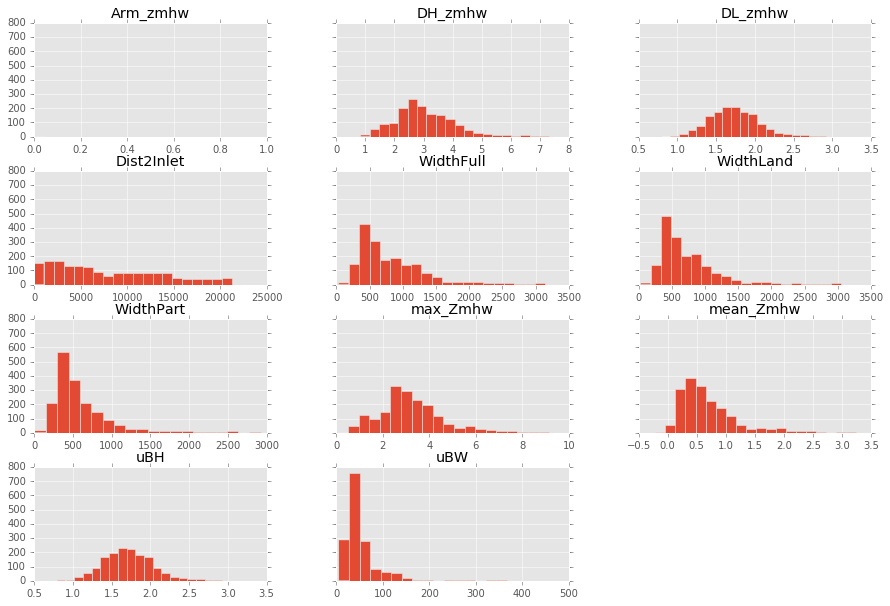

In [31]:
desccols = ['DL_zmhw', 'DH_zmhw', 'Arm_zmhw', 'uBW', 'uBH', 'Dist2Inlet', 
            'WidthPart', 'WidthLand', 'WidthFull', 'mean_Zmhw', 'max_Zmhw']

# Histograms
trans_df.hist(desccols, sharey=True, figsize=[15, 10], bins=20)
plt.show()
plt.close('all')

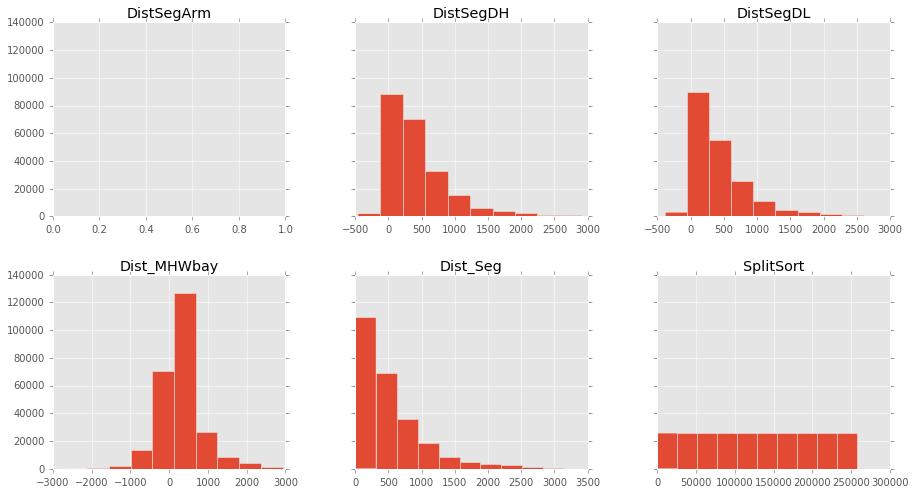

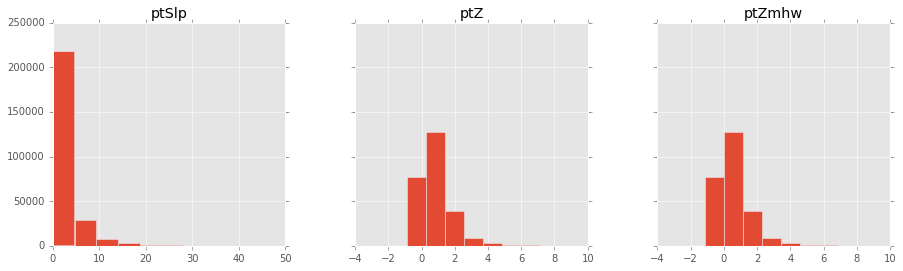

In [32]:
flds_dist = ['SplitSort', 'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm']
flds_z = ['ptZmhw', 'ptZ', 'ptSlp']
pts_df.loc[:,flds_dist+flds_z].describe()
pts_df.hist(flds_dist, sharey=True, figsize=[15, 8], layout=(2,3))
pts_df.hist(flds_z, sharey=True, figsize=[15, 4], layout=(1,3))

plt.show()
plt.close('all')

Transect ID ("sort_ID" 1-1829): 445


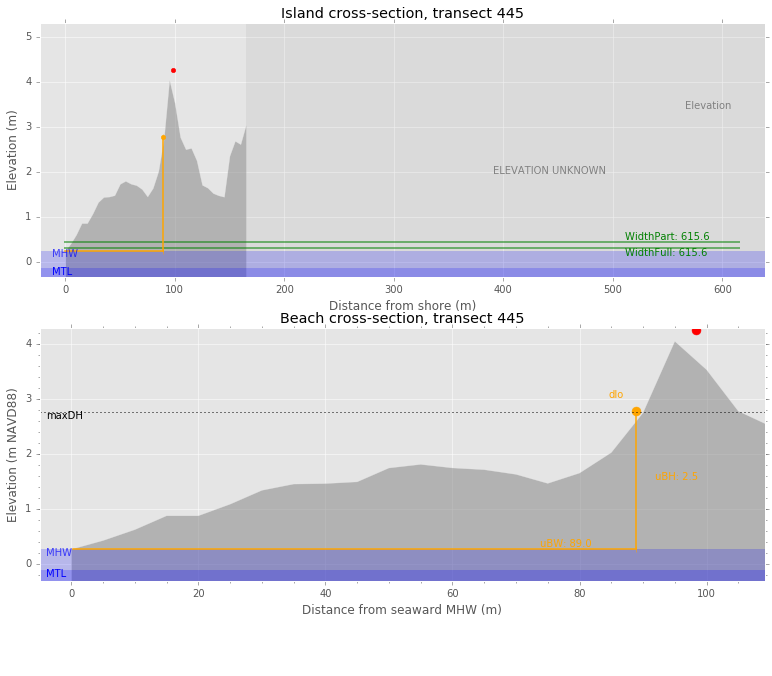

In [35]:
# Prompt for transect identifier (sort_ID) and get all points from that transect.
trans_in = int(input('Transect ID ("sort_ID" {:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

# Plot
fig = plt.figure(figsize=(13,10))

# Plot the width of the island.
ax1 = fig.add_subplot(211)
try:
    fun.plot_island_profile(ax1, pts_set, sitevals['MHW'], sitevals['MTL'])
except TypeError as err:
    print('TypeError: {}'.format(err))
    pass

# Zoom in on the upper beach.
ax2 = fig.add_subplot(212)
try:
    fun.plot_beach_profile(ax2, pts_set, sitevals['MHW'], sitevals['MTL'], maxDH)
except TypeError as err:
    print('TypeError: {}'.format(err))
    pass 

# Display
plt.show()
plt.close('all')

## Outputs

### Transect-averaged
Output the transect-averaged metrics in the following formats:
- transects, unpopulated except for ID values, as gdb feature class
- transects, unpopulated except for ID values, as shapefile
- populated transects with fill values as gdb feature class
- populated transects with null values as gdb feature class
- populated transects with fill values as shapefile
- raster of beach width (__uBW__) by transect

In [36]:
# Load the dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))

#### Vector format

In [142]:
# Create transect file with only ID values and geometry to publish.
trans_flds = ['TRANSECTID', 'TRANSORDER', 'DD_ID']
trans_4pub = fwa.JoinDFtoFC(trans_df.loc[:,trans_flds], extendedTrans, tID_fld, out_fc=sitevals['code']+'_trans')
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_4pub, scratch_dir, sitevals['code']+'_trans.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created calo_trans from input dataframe and extTrans file.
OUTPUT: calo_trans.shp in specified scratch_dir.


In [37]:
# Create transect FC with fill values - Join values from trans_df to the transect FC as a new file.
trans_fc = fwa.JoinDFtoFC(trans_df, extendedTrans, tID_fld, out_fc=trans_name+'_fill')

# Create transect FC with null values
fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=trans_name+'_null', out_dir=home)

# Save final transect SHP with fill values
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, trans_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created calo14_trans_fill from input dataframe and extTrans file.
OUTPUT: calo14_trans_null
OUTPUT: calo14_trans_shp.shp in specified scratch_dir.


#### Raster - beach width
It may be necessary to close any Arc sessions you have open.

In [38]:
# Create a template raster corresponding to the transects. 
if not arcpy.Exists(rst_transID):
    print("{} was not found so we will create the base raster.".format(os.path.basename(rst_transID)))
    outEucAll = arcpy.sa.EucAllocation(extTrans_tidy, maximum_distance=50, cell_size=cell_size, source_field=tID_fld)
    outEucAll.save(os.path.basename(rst_transID))

# Create raster of uBW values by joining trans_df to the template raster.
out_rst = fwa.JoinDFtoRaster(trans_df, os.path.basename(rst_transID), bw_rst, fill, tID_fld, 'uBW')

OUTPUT: calo14_ubw. Field "Value" is ID and "uBW" is beachwidth.


### 5-m points

Output the point metrics in the following formats:
- tabular, in CSV
- populated points with fill values as gdb feature class
- populated points with null values as gdb feature class
- populated points with fill values as shapefile

In [39]:
# Load the saved dataframes
pts_df4csv = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

#### Tabular format

In [40]:
# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, pts_name +'.csv')
pts_df4csv.to_csv(csv_fname, na_rep=fill, index=False)
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(csv_fname)))

OUTPUT: calo14_pts.csv in specified scratch_dir.


#### Vector format

In [41]:
# Convert pts_df to FC - automatically converts NaNs to fills (default fill is -99999)
pts_fc = fwa.DFtoFC_large(pts_df, out_fc=os.path.join(arcpy.env.workspace, pts_name+'_fill'), 
                          spatial_ref=utmSR, df_id=pID_fld, xy=["seg_x", "seg_y"])

# Save final FCs with null values
fwa.CopyFCandReplaceValues(pts_fc, fill, None, out_fc=pts_name+'_null', out_dir=home)

# Save final points as SHP with fill values
out_pts_shp = arcpy.FeatureClassToFeatureClass_conversion(pts_fc, scratch_dir, pts_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_pts_shp))))

Converting points DF to FC...
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: calo14_pts_fill
Duration: 0:21:52.8 seconds
OUTPUT: calo14_pts_null
OUTPUT: calo14_pts_shp.shp in specified scratch_dir.


## Export supplementary files
### Shoreline

In [6]:
# Export the inlet delineation and shoreline polygons to the scratch directory ultimately for publication
arcpy.FeatureClassToFeatureClass_conversion(inletLines, scratch_dir,  pts_name.split('_')[0] + '_inletLines.shp')
arcpy.FeatureClassToFeatureClass_conversion(barrierBoundary, scratch_dir,  pts_name.split('_')[0] + '_shoreline.shp')
print('OUTPUT: Saved inletLines and shoreline shapefiles in the scratch directory.')

OUTPUT: Saved inletLines and shoreline shapefiles in the scratch directory.


## Fix transect ID values

In [9]:
# Add BEARING field to extendedTrans feature class
arcpy.AddGeometryAttributes_management (extendedTrans, 'LINE_BEARING')
print("Adding line bearing field to transects.")

# Copy feature class to dataframe.
trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)
trans_df['DD_ID'] = trans_df[tID_fld] + sitevals['id_init_val']
trans_df.drop('Azimuth', axis=1, inplace=True)
trans_df.rename_axis({"BEARING": "Azimuth"}, axis=1, inplace=True)

# Get anthro fields and join to DF
if 'tr_w_anthro' in locals():
    trdf_anthro = fwa.FCtoDF(tr_w_anthro, id_fld=tID_fld, dffields=['Development', 'Nourishment','Construction'])
    trans_df = fun.join_columns(trans_df, trdf_anthro) 

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# Display
print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
trans_df.head()

Adding line bearing field to transects.
...converting feature class to array...
...converting array to dataframe...
...converting feature class to array...
...converting array to dataframe...

Header of transects dataframe (rows 1-5 out of 1829): 


,OBJECTID_1,Shape,OBJECTID,BaselineID,TransOrder,ProcTime,Autogen,StartX,StartY,EndX,...,LR2,LSE,LCI90,sort_ID,Shape_Length,Azimuth,DD_ID,Development,Nourishment,Construction
sort_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,3513.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,35.416000,40001,111,111,111
2,NaN,NaN,NaN,NaN,3514.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,NaN,35.627176,40002,111,111,111
3,NaN,NaN,NaN,NaN,3515.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,NaN,35.837527,40003,111,111,111
4,NaN,NaN,NaN,NaN,3516.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4,NaN,36.047057,40004,111,111,111
5,NaN,NaN,NaN,NaN,3517.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5,NaN,36.255749,40005,111,111,111


### Calculate distances and sort points

__SplitSort__ is a unique numeric identifier of the 5-m points at the study site, sorted by order along shoreline and by distance from oceanside. __SplitSort__ values are populated by sorting the points by __sort_ID__ and __Dist_Seg__ (see below). 

__Dist_Seg__ is the Euclidean distance between the point and the seaward shoreline (__SL_x__, __SL_y__). __Dist_MHWbay__ is the distance between the point and the bayside shoreline and is calculated by subtracting the __Dist_Seg__ value from the __WidthPart__ value of the transect. 

__DistSegDH__, __DistSegDL__, and __DistSegArm__ measure the distance of each 5-m point from the dune crest and dune toe position along a particular transect. They are calculated as the Euclidean distance between the 5-m point and the given feature. 

In [34]:
# Load saved dataframes
pts_df = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

In [40]:
pts_df['Bslope'] = pts_df['Bslope'].astype(float)
pts_df['Bslope'].sample(10)

89404    -0.072029
169390         NaN
186027   -0.048224
78743    -0.071939
156359   -0.042385
13601    -0.103460
73278    -0.062447
6028     -0.049801
22324    -0.122120
229664   -0.054635
Name: Bslope, dtype: float64

In [41]:
# Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, and sort points (SplitSort)
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)
pts_df = fun.prep_points(pts_df, tID_fld, pID_fld, sitevals['MHW'], fill)

# Aggregate ptZmhw to max and mean and join to transects
pts_df, zmhw = fun.aggregate_z(pts_df, sitevals['MHW'], tID_fld, 'ptZ', fill)
trans_df = fun.join_columns(trans_df, zmhw) 

# Join transect values to pts
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)

# pID_fld needs to be among the columns
if not pID_fld in pts_df.columns:
    pts_df.reset_index(drop=False, inplace=True)

# Match field names to those in sorted_pt_flds list
for fld in pts_df.columns:
    if fld not in sorted_pt_flds:
        for i, fldi in enumerate(sorted_pt_flds):
            if fldi.lower() == fld.lower():
                sorted_pt_flds[i] = fld   
                print(fld)
    
# Drop extra fields and sort columns
trans_df.drop(extra_fields, axis=1, inplace=True, errors='ignore')
for i, f in enumerate(sorted_pt_flds):
    for c in pts_df.columns:
        if f.lower() == c.lower():
            sorted_pt_flds[i] = c
pts_df = pts_df.reindex_axis(sorted_pt_flds, axis=1)

# convert projected coordinates to geographic coordinates (lat, lon in NAD83)
pts_df = fun.add_latlon(pts_df, proj_code)

# Save dataframes 
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

# View random rows from the points DF
pts_df.sample(5)

SplitSort already existed in dataframe, but it was replaced.
TransOrder
TransectId


,SplitSort,seg_x,seg_y,seg_lon,seg_lat,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
238649,238649,402407.6075,3.880717e+06,NaN,NaN,2354.999954,252.748270,2082.919501,2106.714582,NaN,...,3041.072738,3140.974515,248.285188,1.484838,DL,0.348014,3.182489,111,111,111
195005,195005,397061.3396,3.874214e+06,NaN,NaN,509.999822,332.780626,368.340861,NaN,NaN,...,1338.647389,1377.899577,141.296731,1.343752,DH,0.421713,2.661891,111,111,111
157736,157736,388417.4433,3.865739e+06,NaN,NaN,215.000065,285.311808,155.309392,167.772998,NaN,...,500.311873,500.311873,47.221456,1.891327,DL,0.716810,4.054423,111,111,111
198341,198341,397741.2321,3.874586e+06,NaN,NaN,330.000013,420.681060,204.656433,NaN,NaN,...,770.201127,777.536139,125.248068,1.319082,DH,0.512044,1.668730,111,111,111
74851,74851,364261.4900,3.839756e+06,NaN,NaN,770.441500,-473.965429,715.777684,727.013150,NaN,...,658.804252,854.245728,43.302885,1.372132,DL,0.362851,2.593557,111,111,111


In [42]:
# import pyproj

# # Use pyproj to convert projected coordinates to geographic coordinates (lat, lon in NAD83)
# utm = pyproj.Proj(init='epsg:{}'.format(proj_code))
# nad = pyproj.Proj(init='epsg:4269') # NAD83

# in_y = pts_df['seg_y'].tolist()
# in_x = pts_df['seg_x'].tolist()

# lon, lat = pyproj.transform(utm, nad, in_x,in_y)

# lon_col = 'seg_lon'
# lat_col = 'seg_lat'

# pts_df[lon_col] = lon
# pts_df[lat_col] = lat

### Change number of significant digits

- Elevations: 2 significant digits 
- Lengths: 1 (lidar has 15-30 cm resolution in vertical and 1-m-ish in horizontal I believe)
- UTM coords: 2
- lat longs: 6
- LRR: 2

Would be nice if fill value was always integer (not -99999.0 etc.)

In [ ]:
# Round fields to given significant digits
fprecision = {# UTM coordinates
            'seg_x':2, 'seg_y':2, 'SL_x':2, 'SL_y':2, 'DL_x':2, 'DL_y':2,
            'DH_x':2, 'DH_y':2, 'DL_snapX':2, 'DL_snapY':2, 'DH_snapX':2, 'DH_snapY':2, 
            'Arm_x':2, 'Arm_y':2,
            # Geographic coordinates
            'seg_lon':6, 'seg_lat':6,
            # Elevations
            'ptZ':2, 'ptZmhw':2, 'DL_z':2, 'DL_zmhw':2, 'DH_z':2, 'DH_zmhw':2, 
            'Arm_z':2, 'Arm_zmhw':2, 'uBH':2, 'mean_Zmhw':2, 'max_Zmhw':2,
            # Lengths
            'Dist_Seg':1, 'Dist_MHWbay':1, 'DistSegDH':1, 'DistSegDL':1, 'DistSegArm':1,
            'DistDH':1, 'DistDL':1, 'DistArm':1,'Dist2Inlet':1, 'WidthPart':1, 'WidthLand':1, 'WidthFull':1, 'uBW':1,
            # LRR
            'LRR':2,
            # IDs
            'SplitSort':0, 'sort_ID':0, 'TRANSECTID':0, 'TRANSORDER':0, 'DD_ID':0,
            # Other
            'Azimuth':1,'Bslope':4,'ptSlp':4,
            # Coded classifications
            'GeoSet':0, 'SubType':0, 'VegDens':0, 'VegType':0,
            'Construction':0, 'Development':0, 'Nourishment':0}
pts_df = pts_df.round(fprecision)

# Set GeoSet, SubType, VegDens, VegType fields to int32 dtypes
pts_df = pts_df.astype({'GeoSet':'int32', 'SubType':'int32', 'VegDens':'int32', 'VegType':'int32'})

### Recode the values for CSV output and model running

In [43]:
# Recode
pts_df4csv = pts_df.replace({'SubType': {7777:'{1111, 2222}', 1000:'{1111, 3333}'}, 
                              'VegType': {77:'{11, 22}', 88:'{22, 33}', 99:'{33, 44}'},
                              'VegDens': {666: '{111, 222}', 777: '{222, 333}', 
                                          888: '{333, 444}', 999: '{222, 333, 444}'}})

# Fill NAs
pts_df4csv.fillna(fill, inplace=True) 

# Save and view sample
pts_df4csv.to_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df4csv.sample(5)

,SplitSort,seg_x,seg_y,seg_lon,seg_lat,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
245518,245518,403621.2519,3.880035e+06,-76.056918,35.058443,1160.000048,1293.080257,1053.066487,1079.449993,-99999.0,...,2909.843801,2913.816491,79.927633,1.328006,DL,0.639040,4.636446,111,222,111
62900,62900,362059.4269,3.835668e+06,-76.505273,34.653668,350.000017,166.829795,301.172646,312.318415,-99999.0,...,516.829811,516.829811,37.477169,1.437432,DL,0.529460,2.620476,111,111,111
180307,180307,394121.3811,3.871312e+06,-76.159967,34.978851,360.000002,326.966590,209.688799,224.672793,-99999.0,...,877.723794,1114.529500,135.326447,2.011569,DL,0.373831,3.494956,111,111,111
225269,225269,402175.0721,3.878210e+06,-76.072559,35.041849,289.999987,1582.488884,-99999.000000,-99999.000000,-99999.0,...,2021.973682,2074.721913,-99999.000000,-99999.000000,-99999,0.156199,0.963242,111,111,111
211722,211722,399649.6142,3.877000e+06,-76.100098,35.030697,880.000003,299.705376,785.472410,794.222173,-99999.0,...,1206.999917,1230.317515,85.777594,1.703486,DL,0.305958,3.281737,111,111,111


In [8]:
# pts_df4csv = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df4csv.loc[pts_df4csv['TransectId']==1543, ['SL_x', 'SL_y', 'Bslope']]

,SL_x,SL_y,Bslope
257670,-99999.0,-99999.0,-0.011709


### Report field values

In [44]:
# Load dataframe
pts_df4csv = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))

# Create eainfo XML and report field values
xmlfile = os.path.join(scratch_dir, pts_name+'_eainfo.xml')
fun.report_fc_values(pts_df4csv, field_defs, xmlfile)

Number of points in dataset: (257675, 57)

SplitSort______________________________0 | 257674______________   No fills_________No nulls
seg_x_________________348175.84240000043 | 405386.4099000003___   Fills present____No nulls
seg_y_________________3827218.3978000004 | 3881647.3134000003__   Fills present____No nulls
seg_lon_______________-76.65749046702415 | -76.03757562545705__   Fills present____No nulls
seg_lat________________34.57719745333595 | inf_________________   No fills_________No nulls
Dist_Seg_____________________________0.0 | 3141.290244880559___   Fills present____No nulls
Dist_MHWbay___________-2672.495560948987 | 2924.1734002879475__   Fills present____No nulls
DistSegDH____________-457.60556246461687 | 2919.398038209163___   Fills present____No nulls
DistSegDL____________-382.67653815456015 | 2936.490810390518___   Fills present____No nulls
DistSegArm________________________-99999 | -99999______________   ONLY Fills_______No nulls
ptZ__________________-2.0397839546203

[]

#### Tabular format

In [45]:
# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, pts_name +'.csv')
pts_df4csv.to_csv(csv_fname, na_rep=fill, index=False)

sz_mb = os.stat(csv_fname).st_size/(1024.0 * 1024.0)
print("OUTPUT: {} [{} MB] in specified scratch_dir. ".format(os.path.basename(csv_fname), sz_mb))

OUTPUT: calo14_pts.csv [184.84674644470215 MB] in specified scratch_dir. 


#### Vector format

In [46]:
# Convert pts_df to FC - automatically converts NaNs to fills (default fill is -99999)
pts_fc = fwa.DFtoFC_large(pts_df, out_fc=os.path.join(arcpy.env.workspace, pts_name+'_fill'), 
                          spatial_ref=utmSR, df_id=pID_fld, xy=["seg_x", "seg_y"])

# Save final FCs with null values
fwa.CopyFCandReplaceValues(pts_fc, fill, None, out_fc=pts_name+'_null', out_dir=home)

# Save final points as SHP with fill values
out_pts_shp = arcpy.FeatureClassToFeatureClass_conversion(pts_fc, scratch_dir, pts_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_pts_shp))))

Converting points DF to FC...
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: calo14_pts_fill
Duration: 0:38:32.2 seconds
OUTPUT: calo14_pts_null
OUTPUT: calo14_pts_shp.shp in specified scratch_dir.


## Transects

In [17]:
# Create transect file with only ID values and geometry to publish.
trans_flds = ['TRANSECTID', 'TRANSORDER', 'DD_ID', 'MHW']
for i, f in enumerate(trans_flds):
    for c in trans_df.columns:
        if f.lower() == c.lower():
            trans_flds[i] = c
            
trans_4pub = fwa.JoinDFtoFC(trans_df.loc[:,trans_flds], extendedTrans, tID_fld, out_fc=sitevals['code']+'_trans')
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_4pub, scratch_dir, sitevals['code']+'_trans.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created calo_trans from input dataframe and extTrans file.
OUTPUT: calo_trans.shp in specified scratch_dir.


In [18]:
trans_4pubdf = fwa.FCtoDF(trans_4pub)
xmlfile = os.path.join(scratch_dir, trans_4pub + '_eainfo.xml')
trans_df_extra_flds = fun.report_fc_values(trans_4pubdf, field_defs, xmlfile)

...converting feature class to array...
...converting array to dataframe...
Number of points in dataset: (1829, 7)

Shape............... nan
sort_ID________________________________1 | 1829________________   No fills_________No nulls
Shape_Length__________1098.6812181158107 | 4799.999802442252___   No fills_________No nulls
TransectId__________________________34.0 | 3745.0______________   No fills_______Nulls present
TransOrder__________________________34.0 | 3745.0______________   No fills_______Nulls present
DD_ID______________________________40001 | 41829_______________   No fills_________No nulls



In [ ]:
# Delete extra fields from points feature class
if len(trans_df_extra_flds) > 0:
    for fld in trans_df_extra_flds:
        try:
            arcpy.DeleteField_management(trans_4pub, fld)
            print('Deleted field "{}"'.format(fld))
        except:
            print('WARNING: Failed to delete field "{}"'.format(fld))
            pass

In [48]:
# Create transect FC with fill values - Join values from trans_df to the transect FC as a new file.
trans_fc = fwa.JoinDFtoFC_2(trans_df, extendedTrans, tID_fld, out_fc=trans_name+'_fill')

# Create transect FC with null values
fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=trans_name+'_null', out_dir=home)

# Save final transect SHP with fill values
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, trans_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

OUTPUT: calo14_trans_null
OUTPUT: calo14_trans_shp.shp in specified scratch_dir.


## Rerun sections

#### Shoreline

Using the easting and northing for the position is .8 m off. Do we put more store by the coordinates in the attribute table or the coordinates in the feature geometry?

In [26]:
morph_pts_name = pts_name.split('_')[0] + '_SLpts'

# Convert to pandas DF
slpts_df = fwa.FCtoDF(ShorelinePts, xy=True)
slpts_df.head()

Converting feature class to array with X and Y...
...converting array to dataframe...


,OBJECTID,Shape,state,seg,profile,sl_x,ci95_slx,slope,easting,northing,SHAPE@X,SHAPE@Y
0,1,NaN,11,10,208,224.80851,0.015294,-0.09775,348733.902140,3.838923e+06,348733.902135,3.838923e+06
1,2,NaN,11,10,209,225.00514,0.028938,-0.099977,348742.650605,3.838918e+06,348742.650600,3.838918e+06
2,3,NaN,11,10,210,225.10087,0.018068,-0.10063,348751.446229,3.838914e+06,348751.446224,3.838914e+06
3,4,NaN,11,10,227,236.76539,0.104823,-0.10546,348896.280365,3.838824e+06,348896.280360,3.838824e+06
4,5,NaN,11,10,228,236.39493,0.097376,-0.10533,348905.293899,3.838820e+06,348905.293895,3.838820e+06


In [33]:
# Convert fields sl_x and slope to float. 
# slpts_df['sl_x'] = slpts_df.sl_x.astype(float)
# slpts_df['slope'] = slpts_df.slope.astype(float)
print(slpts_df.dtypes)

OBJECTID      int32
Shape       float64
state         int32
seg           int32
profile       int32
sl_x        float64
ci95_slx    float64
slope       float64
easting     float64
northing    float64
SHAPE@X     float64
SHAPE@Y     float64
dtype: object


In [28]:
# Convert dataframe to feature class - shoreline points
new_fc = os.path.join(arcpy.env.workspace, morph_pts_name+'_fromDF')
fwa.DFtoFC(slpts_df, os.path.join(arcpy.env.workspace, new_fc), 
           spatial_ref=utmSR, id_fld='', xy=["SHAPE@X", "SHAPE@Y"], 
           keep_fields=['state', 'seg', 'profile', 'sl_x', 'ci95_slx', 'slope','easting','northing'])
print('OUTPUT: {} in designated geodatabase.'.format(os.path.basename(new_fc)))

... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: calo14_SLpts_fromDF in designated geodatabase.


In [31]:
# Report values
xmlfile = os.path.join(scratch_dir, morph_pts_name + '_eainfo.xml')
sldf_extra_flds = fun.report_fc_values(slpts_df, field_defs, xmlfile)

Number of points in dataset: (6068, 12)

OBJECTID_______________________________1 | 6068________________   No fills_________No nulls
Shape............... nan
state............... 11
seg___________________________________10 | 15__________________   No fills_________No nulls
profile________________________________1 | 1791________________   No fills_________No nulls
sl_x__________________________-1746.0123 | 2776.5783___________   No fills_________No nulls
ci95_slx_________________________2.7e-05 | 0.619495____________   No fills_________No nulls
slope___________________________-0.14546 | -0.0006643__________   No fills_________No nulls
easting_____________________348733.90214 | 405373.746781_______   No fills_________No nulls
northing___________________3827510.95552 | 3880285.90049_______   No fills_________No nulls



In [30]:
fieldlist = [f.name for f in arcpy.ListFields(new_fc)]
fieldlist

['OBJECTID',
 'Shape',
 'index',
 'state',
 'seg',
 'profile',
 'sl_x',
 'ci95_slx',
 'slope',
 'easting',
 'northing']

In [10]:
# Make sure the column names match the expected field names
slfc_extra_flds = []
for fld in fieldlist:
    print(fld)
    found = False
    if fld not in field_defs.keys():
        for fldi in field_defs.keys():
            if fldi.lower() == fld.lower():
                found = True
                print('Different capitalization found: {} -- {}'.format(fld, fldi))
    else:
        found = True
    if not found:
        slfc_extra_flds += [fld]
slfc_extra_flds

OBJECTID
Shape
index
state
seg
profile
sl_x
ci95_slx
slope
easting
northing


['index']

In [11]:
# Delete extra fields from points feature class
if len(slfc_extra_flds) > 0:
    for fld in slfc_extra_flds:
        try:
            arcpy.DeleteField_management(new_fc, fld)
            print('Deleted field "{}"'.format(fld))
        except:
            print('WARNING: Failed to delete field "{}"'.format(fld))
            pass
arcpy.Delete_management(morph_pts_name + '.shp')
arcpy.FeatureClassToFeatureClass_conversion(new_fc, scratch_dir,  morph_pts_name + '.shp')
print("\nOUTPUT: {} in specified scratch_dir.".format(os.path.basename(morph_pts_name + '.shp')))

# Delete extra fields from dataframe (which will become CSV)
slpts_df.drop(sldf_extra_flds, axis=1, inplace=True)

# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, morph_pts_name + '.csv')
slpts_df.to_csv(csv_fname, na_rep=fill, index=False)
sz_mb = os.stat(csv_fname).st_size/(1024.0 * 1024.0)
print("\nOUTPUT: {} (size: {:.2f} MB) in specified scratch_dir.".format(os.path.basename(csv_fname), sz_mb))

Deleted field "index"

OUTPUT: calo14_SLpts.shp in specified scratch_dir.

OUTPUT: calo14_SLpts.csv (size: 0.47 MB) in specified scratch_dir.


#### DHpts

In [12]:
morph_pts_name = pts_name.split('_')[0] + '_DCpts'

# Convert to pandas DF
pts_df = fwa.FCtoDF(dhPts, xy=True)

# Convert fields sl_x and slope to float. 
pts_df['dhigh_x'] = pts_df.dhigh_x.astype(float)
pts_df.drop(['lon', 'lat'], axis=1, inplace=True)

Converting feature class to array with X and Y...
...converting array to dataframe...


In [13]:
pts_df.head()

,OBJECTID,Shape,state,seg,profile,easting,northing,dhigh_x,dhigh_z,z_error,SHAPE@X,SHAPE@Y
0,1,NaN,11,10,118,348204.012092,3.839847e+06,-343.72818,1.166804,0.296118,348204.012087,3.839847e+06
1,2,NaN,11,10,119,348212.852464,3.839842e+06,-343.72818,1.512477,0.206217,348212.852459,3.839842e+06
2,3,NaN,11,10,120,348220.524295,3.839835e+06,-341.22818,1.630238,0.113412,348220.524290,3.839835e+06
3,4,NaN,11,10,121,348228.196126,3.839828e+06,-338.72818,1.667947,0.111664,348228.196121,3.839828e+06
4,5,NaN,11,10,122,348237.036498,3.839823e+06,-338.72818,1.591716,0.155557,348237.036493,3.839823e+06


In [14]:
# Convert dataframe to feature class - shoreline points
new_fc = os.path.join(arcpy.env.workspace, 'caha14_DHpts_fromDF')
keepfields = ['state', 'seg', 'profile', 'easting', 'northing', 'dhigh_x','dhigh_z','z_error']
fwa.DFtoFC(pts_df, os.path.join(arcpy.env.workspace, new_fc), 
           spatial_ref=utmSR, id_fld='', xy=["SHAPE@X", "SHAPE@Y"], 
           keep_fields=keepfields)
print('OUTPUT: {} in designated geodatabase.'.format(os.path.basename(new_fc)))

... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: caha14_DHpts_fromDF in designated geodatabase.


In [15]:
# Report values
xmlfile = os.path.join(scratch_dir, morph_pts_name + '_eainfo.xml')
df_extra_flds = fun.report_fc_values(pts_df, field_defs, xmlfile)

Number of points in dataset: (7501, 12)

OBJECTID_______________________________1 | 8125________________   No fills_________No nulls
Shape............... nan
state............... 11
seg___________________________________10 | 15__________________   No fills_________No nulls
profile________________________________1 | 1831________________   No fills_________No nulls
easting____________________348204.012092 | 405310.076919_______   No fills_________No nulls
northing__________________3828889.568249 | 3880025.275172______   No fills_________No nulls
dhigh_x_______________________-1814.7839 | 221.28944___________   No fills_________No nulls
dhigh_z_________________________1.030004 | 7.634427____________   No fills_________No nulls
z_error__________________________0.01062 | 1.47014_____________   No fills_________No nulls



In [16]:
fieldlist = [f.name for f in arcpy.ListFields(new_fc)]
fieldlist

['OBJECTID',
 'Shape',
 'index',
 'state',
 'seg',
 'profile',
 'easting',
 'northing',
 'dhigh_x',
 'dhigh_z',
 'z_error']

In [17]:
# Make sure the column names match the expected field names
fc_extra_flds = []
for fld in fieldlist:
    found = False
    if fld not in field_defs.keys():
        for fldi in field_defs.keys():
            if fldi.lower() == fld.lower():
                found = True
                print('Different capitalization found: {} -- {}'.format(fld, fldi))
    else:
        found = True
    if not found:
        fc_extra_flds += [fld]
        
print('Extra fields: {}'.format(fc_extra_flds))

Extra fields: ['index']


In [18]:
# Delete extra fields from points feature class
if len(fc_extra_flds) > 0:
    for fld in fc_extra_flds:
        try:
            arcpy.DeleteField_management(new_fc, fld)
            print('Deleted field "{}"'.format(fld))
        except:
            print('WARNING: Failed to delete field "{}"'.format(fld))
            pass
pts_shp_name = morph_pts_name + '.shp'
arcpy.Delete_management(pts_shp_name)
arcpy.FeatureClassToFeatureClass_conversion(new_fc, scratch_dir,  pts_shp_name)
print("\nOUTPUT: {} in specified scratch_dir.".format(os.path.basename(pts_shp_name)))

# Delete extra fields from dataframe (which will become CSV)
pts_df.drop(df_extra_flds, axis=1, inplace=True)

# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, morph_pts_name + '.csv')
pts_df.to_csv(csv_fname, na_rep=fill, index=False)
sz_mb = os.stat(csv_fname).st_size/(1024.0 * 1024.0)
print("\nOUTPUT: {} (size: {:.2f} MB) in specified scratch_dir.".format(os.path.basename(csv_fname), sz_mb))

Deleted field "index"

OUTPUT: calo14_DCpts.shp in specified scratch_dir.

OUTPUT: calo14_DCpts.csv (size: 0.58 MB) in specified scratch_dir.


#### DLpts

In [19]:
morph_pts_name = pts_name.split('_')[0] + '_DTpts'

# Convert to pandas DF
pts_df = fwa.FCtoDF(dlPts, xy=True)
pts_df.head()

Converting feature class to array with X and Y...
...converting array to dataframe...


,OBJECTID,Shape,state,seg,profile,lon,lat,easting,northing,dlow_x,dlow_z,z_error,SHAPE@X,SHAPE@Y
0,1,NaN,11,10,197,-76.652,34.682132,348668.693228,3.839035e+06,156.27182,1.912603,0.349341,348668.693223,3.839035e+06
1,2,NaN,11,10,210,-76.651,34.681170,348758.494427,3.838927e+06,210.02182,1.963626,0.248273,348758.494422,3.838927e+06
2,8,NaN,11,10,241,-76.6479,34.680015,349038.972940,3.838794e+06,196.27182,1.787099,0.175153,349038.972935,3.838794e+06
3,9,NaN,11,10,242,-76.6478,34.679974,349047.813312,3.838790e+06,196.27182,1.897195,0.120502,349047.813307,3.838790e+06
4,10,NaN,11,10,243,-76.6477,34.679933,349056.653684,3.838785e+06,196.27182,1.859350,0.165605,349056.653679,3.838785e+06


In [20]:
# Convert fields sl_x and slope to float. 
pts_df['dlow_x'] = pts_df.dlow_x.astype(float)
pts_df.drop(['lon', 'lat'], axis=1, inplace=True)
pts_df.dtypes

OBJECTID      int32
Shape       float64
state         int32
seg           int32
profile       int32
easting     float64
northing    float64
dlow_x      float64
dlow_z      float64
z_error     float64
SHAPE@X     float64
SHAPE@Y     float64
dtype: object

In [21]:
# Convert dataframe to feature class - shoreline points
new_fc = os.path.join(arcpy.env.workspace, 'caha14_DLpts_fromDF')
keepfields = ['state', 'seg', 'profile', 'easting', 'northing', 'dlow_x','dlow_z','z_error']
fwa.DFtoFC(pts_df, os.path.join(arcpy.env.workspace, new_fc), 
           spatial_ref=utmSR, id_fld='', xy=["SHAPE@X", "SHAPE@Y"], 
           keep_fields=keepfields)
print('OUTPUT: {} in designated geodatabase.'.format(os.path.basename(new_fc)))

... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: caha14_DLpts_fromDF in designated geodatabase.


In [22]:
# Report values
xmlfile = os.path.join(scratch_dir, morph_pts_name + '_eainfo.xml')
df_extra_flds = fun.report_fc_values(pts_df, field_defs, xmlfile)

Number of points in dataset: (6194, 12)

OBJECTID_______________________________1 | 6199________________   No fills_________No nulls
Shape............... nan
state............... 11
seg___________________________________10 | 15__________________   No fills_________No nulls
profile________________________________1 | 1831________________   No fills_________No nulls
easting____________________348668.693228 | 405098.572951_______   No fills_________No nulls
northing__________________3828884.386007 | 3879670.408811______   No fills_________No nulls
dlow_x________________________-1781.0339 | 222.52182___________   No fills_________No nulls
dlow_z__________________________0.956625 | 3.471652____________   No fills_________No nulls
z_error_________________________0.017328 | 1.317179____________   No fills_________No nulls



In [23]:
fieldlist = [f.name for f in arcpy.ListFields(new_fc)]
fieldlist

['OBJECTID',
 'Shape',
 'index',
 'state',
 'seg',
 'profile',
 'easting',
 'northing',
 'dlow_x',
 'dlow_z',
 'z_error']

In [24]:
# Make sure the column names match the expected field names
fc_extra_flds = []
for fld in fieldlist:
    found = False
    if fld not in field_defs.keys():
        for fldi in field_defs.keys():
            if fldi.lower() == fld.lower():
                found = True
                print('Different capitalization found: {} -- {}'.format(fld, fldi))
    else:
        found = True
    if not found:
        fc_extra_flds += [fld]
        
print('Extra fields: {}'.format(fc_extra_flds))

Extra fields: ['index']


In [25]:
# Delete extra fields from points feature class
if len(fc_extra_flds) > 0:
    for fld in fc_extra_flds:
        try:
            arcpy.DeleteField_management(new_fc, fld)
            print('Deleted field "{}"'.format(fld))
        except:
            print('WARNING: Failed to delete field "{}"'.format(fld))
            pass
pts_shp_name = morph_pts_name + '.shp'
arcpy.Delete_management(pts_shp_name)
arcpy.FeatureClassToFeatureClass_conversion(new_fc, scratch_dir,  pts_shp_name)
print("\nOUTPUT: {} in specified scratch_dir.".format(os.path.basename(pts_shp_name)))

# Delete extra fields from dataframe (which will become CSV)
pts_df.drop(df_extra_flds, axis=1, inplace=True)

# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, morph_pts_name + '.csv')
pts_df.to_csv(csv_fname, na_rep=fill, index=False)
sz_mb = os.stat(csv_fname).st_size/(1024.0 * 1024.0)
print("\nOUTPUT: {} (size: {:.2f} MB) in specified scratch_dir.".format(os.path.basename(csv_fname), sz_mb))

Deleted field "index"

OUTPUT: calo14_DTpts.shp in specified scratch_dir.

OUTPUT: calo14_DTpts.csv (size: 0.48 MB) in specified scratch_dir.
